
# I- Contrastive loss for CIfAR10



### Imports

In [13]:
from cifar10_utils import *
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers,optimizers
from tensorflow.keras.layers import Input,Lambda,Flatten,MaxPooling2D,Dropout,Conv2D,BatchNormalization
exec(open('cifar10_utils.py').read())

    
## 1- Prepare train sets and test sets

### a- train sets

In [2]:
train_images,train_labels,test_images,test_labels = load_CIFAR10_data()

170500096/170498071 [==============================] - 4s 0us/step


In [3]:
### all_train[i] contains all train images of class i
all_train, all_test = data_groupby_class(train_images,train_labels,test_images,test_labels)

Let's only consider examples of classes 0,1,2,3,4 for training our network using contrastive loss

Classes 5 to 9 are left out and are the following : 

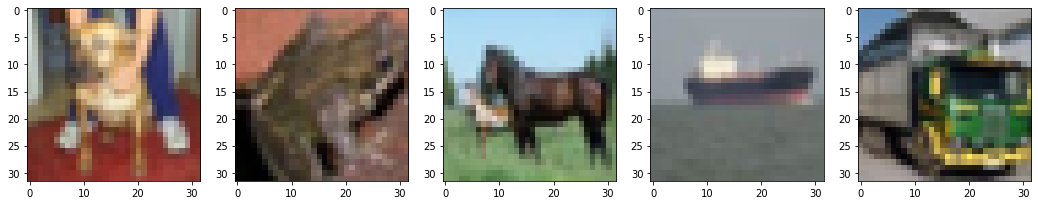

In [ ]:

fig=plt.figure(figsize=(18, 18))
fig.add_subplot(1,5,1)
plt.imshow(all_train[5][2].reshape(32,32,3))
fig.add_subplot(1,5,2)
plt.imshow(all_train[6][10].reshape(32,32,3))
fig.add_subplot(1,5,3)
plt.imshow(all_train[7][2].reshape(32,32,3))
fig.add_subplot(1,5,4)
plt.imshow(all_train[8][2].reshape(32,32,3))
fig.add_subplot(1,5,5)
plt.imshow(all_train[9][2].reshape(32,32,3))
plt.show()

###Prepare pairs of examples for training, keep only classes 0 to 4 

In [15]:
n_pairs_same = 4000
n_pairs_diff = 4500
pairs_same,labels_same = prepare_same_pairs(all_train,n_pairs_same,'train')
pairs_diff,labels_diff = prepare_different_pairs(all_train,n_pairs_diff,'train')

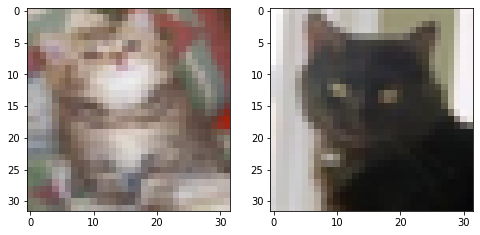

In [ ]:
### Same pair of cifar-10 images
fig=plt.figure(figsize=(8, 8))
fig.add_subplot(1,2,1)
plt.imshow(pairs_same[10,:,0].reshape(32,32,3))
fig.add_subplot(1,2,2)
plt.imshow(pairs_same[10,:,1].reshape(32,32,3))

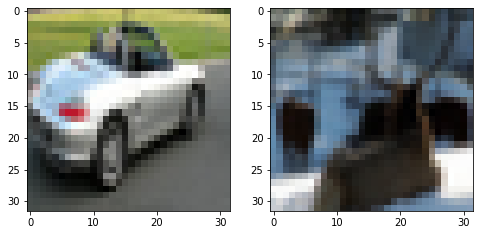

In [ ]:
### Differente pair of cifar-10 images
fig=plt.figure(figsize=(8, 8))
fig.add_subplot(1,2,1)
plt.imshow(pairs_diff[4,:,0].reshape(32,32,3))
fig.add_subplot(1,2,2)
plt.imshow(pairs_diff[4,:,1].reshape(32,32,3))

create y such as equals 1 if pairs are from the same class, 0 otherwise :

In [16]:
y = np.array([1.]*n_pairs_same + [0.]*n_pairs_diff)
x = np.concatenate([pairs_same, pairs_diff], axis = 0)

In [17]:
x_train, y_train = shuffle(x, y, random_state=0)

In [ ]:
x_train.shape,y_train.shape

((8500, 3072, 2), (8500,))

###b- Create test sets

Create medium test set with all classes¶

In [19]:
n_pairs_same = 4000
n_pairs_diff = 4500
pairs_same_test,labels_same_test = prepare_same_pairs(all_test,n_pairs_same,'test')
pairs_diff_test,labels_diff_test = prepare_different_pairs(all_test,n_pairs_diff,'test')

y_test = np.array([1.]*n_pairs_same + [0.]*n_pairs_diff)
x_test = np.concatenate([pairs_same_test, pairs_diff_test], axis = 0)

x_test, y_test = shuffle(x_test, y_test, random_state=0)


Create hard test set with only classes 5-9

In [20]:
n_pairs_same = 4000
n_pairs_diff = 4500
pairs_same_test,labels_same_test = prepare_same_pairs_test(all_test,n_pairs_same,'hard')
pairs_diff_test,labels_diff_test = prepare_different_pairs_test(all_test,n_pairs_diff,'hard')

y_test_hard = np.array([1.]*n_pairs_same + [0.]*n_pairs_diff)
x_test_hard = np.concatenate([pairs_same_test, pairs_diff_test], axis = 0)

x_test_hard, y_test_hard = shuffle(x_test_hard, y_test_hard, random_state=0)

Create easy test set with only classes 0-4¶


In [21]:
n_pairs_same = 4000
n_pairs_diff = 4500
pairs_same_test,labels_same_test = prepare_same_pairs_test(all_test,n_pairs_same,'easy')
pairs_diff_test,labels_diff_test = prepare_different_pairs_test(all_test,n_pairs_diff,'easy')

y_test_easy = np.array([1.]*n_pairs_same + [0.]*n_pairs_diff)
x_test_easy = np.concatenate([pairs_same_test, pairs_diff_test], axis = 0)

x_test_easy, y_test_easy = shuffle(x_test_easy, y_test_easy, random_state=0)

## 1- First CNN without classes 5 to 9 : 

### 1-1- Transfer learning

Let's do some transfer learning first : 

In [7]:
## classification model for cifar10
def build_model_base_CNN(input_shape):
  input = Input(shape=input_shape)
  weight_decay = 1e-4
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer= regularizers.l2(weight_decay), padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer= regularizers.l2(weight_decay), padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer= regularizers.l2(weight_decay), padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer= regularizers.l2(weight_decay), padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.3))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer= regularizers.l2(weight_decay), padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer= regularizers.l2(weight_decay), padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer= regularizers.l2(weight_decay)))
  model.add(Dropout(0.2))
  model.add(Dense(10, activation='softmax'))
  # compile model
  opt = optimizers.RMSprop(lr=0.001,decay=1e-6)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [8]:
### train a cnn classification model on xt, yt and after that use its weights 
from tensorflow.keras import layers
from tensorflow.keras import activations
from keras.callbacks import EarlyStopping,ModelCheckpoint

#prepare data for fitting the transfered model
xtr = train_images.reshape(train_images.shape[0],32,32,3)
ytr = keras.utils.to_categorical(train_labels, 10) 
xte = test_images.reshape(test_images.shape[0],32,32,3)
yte = keras.utils.to_categorical(test_labels, 10)

tmodel = build_model_base_CNN(xtr.shape[1:])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=15)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

tmodel.fit(xtr, ytr, epochs=100, batch_size=64,verbose=1,validation_data=(xte,yte), callbacks=[es,mc])

Epoch 1/100
782/782 [==============================] - ETA: 0s - loss: 1.7077 - accuracy: 0.4365
Epoch 00001: val_accuracy improved from -inf to 0.55160, saving model to best_model.h5
782/782 [==============================] - 8s 11ms/step - loss: 1.7077 - accuracy: 0.4365 - val_loss: 1.4126 - val_accuracy: 0.5516
Epoch 2/100
782/782 [==============================] - ETA: 0s - loss: 1.2564 - accuracy: 0.6114
Epoch 00002: val_accuracy improved from 0.55160 to 0.64720, saving model to best_model.h5
782/782 [==============================] - 8s 10ms/step - loss: 1.2564 - accuracy: 0.6114 - val_loss: 1.2095 - val_accuracy: 0.6472
Epoch 3/100
780/782 [============================>.] - ETA: 0s - loss: 1.0874 - accuracy: 0.6768
Epoch 00003: val_accuracy improved from 0.64720 to 0.71250, saving model to best_model.h5
782/782 [==============================] - 8s 10ms/step - loss: 1.0876 - accuracy: 0.6768 - val_loss: 0.9797 - val_accuracy: 0.7125
Epoch 4/100
779/782 [=========================

In [10]:
tmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

In [9]:
#remove last layer for classification (activation softmax) and replace it with another layer giving the encodings of the images
from keras.models import load_model
saved_model = load_model('./best_model.h5')
tmodel_modified = Sequential()
for layer in saved_model.layers[:-1]: # go through until last layer
  tmodel_modified.add(layer)
tmodel_modified.add(layers.Activation(activations.relu))
tmodel_modified.build((None,32,32,3))
tmodel_modified.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)       

### 1-2- Build and train the siamese model with contrastive loss 

In [23]:
shape = x_train.shape
x_train = x_train.reshape((shape[0],32,32,3,shape[2]))

test_shape= x_test.shape
x_test = x_test.reshape((test_shape[0],32,32,3,test_shape[2]))

test_shape= x_test_hard.shape
x_test_hard = x_test_hard.reshape(test_shape[0],32,32,3,test_shape[2])

test_shape= x_test_easy.shape
x_test_easy = x_test_easy.reshape(test_shape[0],32,32,3,test_shape[2])

In [ ]:
### hyperparameters of the model
from keras.callbacks import EarlyStopping
nb_epochs = 10
batch_size = 64

es = EarlyStopping(monitor='val_loss', mode='max', verbose=1)

### model
input_shape = x_train.shape[1:4]

base_network_contrastive1 = tf.keras.models.clone_model(tmodel_modified)
base_network_contrastive1.set_weights(tmodel_modified.get_weights()) 

# 2 parallel branches with the same weights of the same base network
branch1 = Input(input_shape)
branch2 = Input(input_shape)

processed1 = base_network_contrastive1(branch1)
processed2 = base_network_contrastive1(branch2)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed1, processed2])

model = Model([branch1, branch2], distance)

model.compile(loss=contrastive_loss, optimizer='rmsprop')
history = model.fit([x_train[:,:,:,:, 0], x_train[:,:,:,:, 1]], y_train, batch_size=batch_size, epochs=nb_epochs,
                    validation_data=([x_test[:,:,:,:, 0],x_test[:,:,:,:, 1]],y_test) )

pred_train = model.predict([x_train[:,:,:,:,0], x_train[:,:,:,:,1]])
acc = compute_accuracy(pred_train, y_train,0.5)
print('train accuracy of our model = ',acc)

Epoch 1/10
133/133 [==============================] - 3s 23ms/step - loss: 0.9691 - val_loss: 0.5412
Epoch 2/10
133/133 [==============================] - 3s 19ms/step - loss: 0.4808 - val_loss: 0.4410
Epoch 3/10
133/133 [==============================] - 3s 19ms/step - loss: 0.4221 - val_loss: 0.4093
Epoch 4/10
133/133 [==============================] - 3s 19ms/step - loss: 0.3797 - val_loss: 0.3568
Epoch 5/10
133/133 [==============================] - 3s 20ms/step - loss: 0.3515 - val_loss: 0.3555
Epoch 6/10
133/133 [==============================] - 3s 19ms/step - loss: 0.3241 - val_loss: 0.3521
Epoch 7/10
133/133 [==============================] - 3s 20ms/step - loss: 0.3066 - val_loss: 0.3436
Epoch 8/10
133/133 [==============================] - 3s 20ms/step - loss: 0.2960 - val_loss: 0.3114
Epoch 9/10
133/133 [==============================] - 3s 20ms/step - loss: 0.2848 - val_loss: 0.2930
Epoch 10/10
133/133 [==============================] - 3s 20ms/step - loss: 0.2725 - val_lo

accuracy on medium test set

In [ ]:
pred_test = model.predict([x_test[:,:,:,:,0], x_test[:,:,:,:,1]])
acc_test = compute_accuracy(pred_test, y_test,0.5)
print('Test accuracy of our model = ' ,acc_test)

Test accuracy of our model =  0.7107058823529412


accuracy on hard test set



In [ ]:
pred_test_hard = model.predict([x_test_hard[:,:,:,:,0], x_test_hard[:,:,:,:,1]])
acc_test_hard = compute_accuracy(pred_test_hard, y_test_hard,0.5)
print('Test accuracy of our model = ' ,acc_test_hard)

Test accuracy of our model =  0.6803529411764706


accuracy on easy test set

In [ ]:
pred_test_easy = model.predict([x_test_easy[:,:,:,:,0], x_test_easy[:,:,:,:,1]])
acc_test_easy = compute_accuracy(pred_test_easy, y_test_easy,0.5)
print('Test accuracy of our model = ' ,acc_test_easy)

Test accuracy of our model =  0.7928235294117647


### 1- 3 - Impact of the threshold on the accuracy

train and easy data set



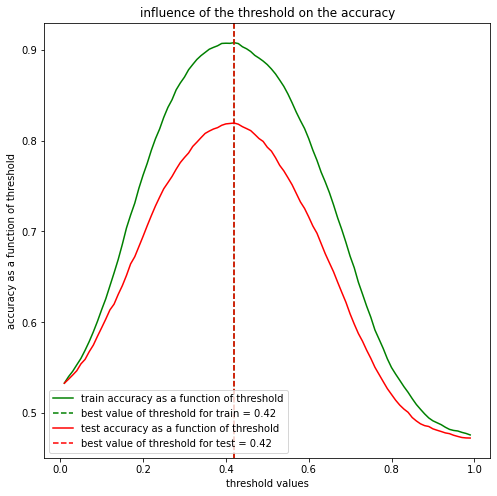

In [ ]:
best_train_threshold,best_test_threshold = threshold_plot(pred_test_easy, y_test_easy,pred_train, y_train)

train and hard data set

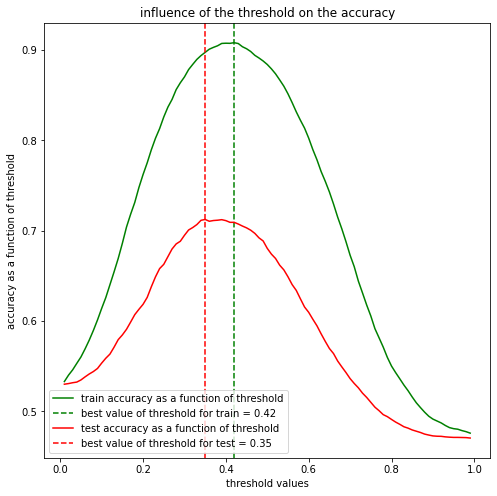

In [ ]:
best_train_threshold,best_test_threshold = threshold_plot(pred_test_hard, y_test_hard,pred_train, y_train)

train and medium dataset 

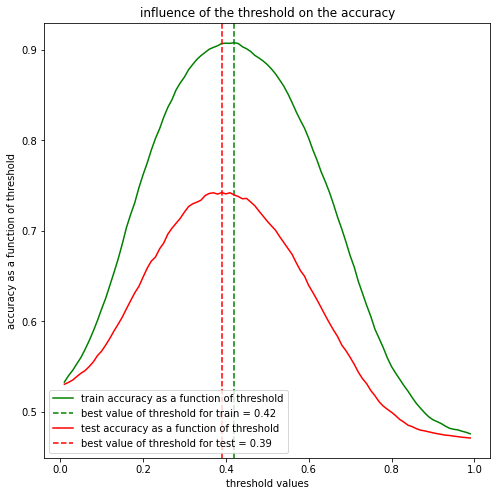

In [ ]:
best_train_threshold,best_test_threshold = threshold_plot(pred_test, y_test,pred_train, y_train)

In [ ]:
acc_train = compute_accuracy(pred_train, y_train,best_train_threshold)
acc_test = compute_accuracy(pred_test, y_test,best_test_threshold)
print('train accuracy of our best first model = ',acc_train)
print('test accuracy of our best first model = ',acc_test)
print('best threshold is ',best_test_threshold)

train accuracy of our best first model =  0.9014117647058824
test accuracy of our best first model =  0.7265882352941176
best threshold is  0.38


## 2- Build the second CNN with classes 5 to 9

Let's add One example for class 5, one example for class 6, one example for class 7, one example for class 7, one example for class 8 and one example for class 9 in the training set  and then let's see if the model is capable of distinguishing these new classes 

### 2-1- Prepare the data, define the model, train and test It

In [29]:
n_pairs_same = 3500
n_pairs_diff = 4000
pairs_same,labels_same = prepare_same_pairs2(all_train,n_pairs_same,'train')
pairs_diff,labels_diff = prepare_different_pairs2(all_train,n_pairs_diff,'test')

y2 = np.array([1.]*n_pairs_same + [0.]*n_pairs_diff)
x2 = np.concatenate([pairs_same, pairs_diff], axis = 0)

x_train2, y_train2 = shuffle(x2, y2, random_state=0)

shape = x_train2.shape
x_train2 = x_train2.reshape((shape[0],32,32,3,shape[2]))

In [ ]:
### hyperparameters of the model
nb_epochs = 10
batch_size = 64

### model
input_shape = x_train2.shape[1:4]

base_network_contrastive2 = tf.keras.models.clone_model(tmodel_modified)
base_network_contrastive2.set_weights(tmodel_modified.get_weights()) 

# 2 parallel branches with the same weights of the same base network
branch1 = Input(input_shape)
branch2 = Input(input_shape)

processed1 = base_network_contrastive2(branch1)
processed2 = base_network_contrastive2(branch2)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed1, processed2])

model = Model([branch1, branch2], distance)

model.compile(loss=contrastive_loss, optimizer='rmsprop')
history2 = model.fit([x_train2[:,:,:,:, 0], x_train2[:,:,:,:, 1]], y_train2, batch_size=batch_size, epochs=nb_epochs, validation_split = 0.2)

pred_train = model.predict([x_train2[:,:,:,:,0], x_train2[:,:,:,:,1]])
acc = compute_accuracy(pred_train, y_train2,0.5)
print('train accuracy of our model = ',acc)

Epoch 1/10
94/94 [==============================] - 2s 19ms/step - loss: 1.1453 - val_loss: 0.4433
Epoch 2/10
94/94 [==============================] - 2s 16ms/step - loss: 0.4244 - val_loss: 0.4129
Epoch 3/10
94/94 [==============================] - 2s 16ms/step - loss: 0.3850 - val_loss: 0.3818
Epoch 4/10
94/94 [==============================] - 1s 16ms/step - loss: 0.3528 - val_loss: 0.3764
Epoch 5/10
94/94 [==============================] - 1s 16ms/step - loss: 0.3389 - val_loss: 0.3551
Epoch 6/10
94/94 [==============================] - 1s 16ms/step - loss: 0.3228 - val_loss: 0.3556
Epoch 7/10
94/94 [==============================] - 1s 16ms/step - loss: 0.3101 - val_loss: 0.3488
Epoch 8/10
94/94 [==============================] - 1s 16ms/step - loss: 0.2932 - val_loss: 0.3461
Epoch 9/10
94/94 [==============================] - 1s 16ms/step - loss: 0.2810 - val_loss: 0.3461
Epoch 10/10
94/94 [==============================] - 2s 16ms/step - loss: 0.2702 - val_loss: 0.3382
train acc

accuracy on medium dataset

In [ ]:
pred_test = model.predict([x_test[:,:,:,:,0], x_test[:,:,:,:,1]])
acc_test = compute_accuracy(pred_test, y_test,0.5)
print('Test accuracy of our model = ' ,acc_test)

Test accuracy of our model =  0.59


accuracy on easy dataset

In [ ]:
pred_test_easy = model.predict([x_test_easy[:,:,:,:,1], x_test_easy[:,:,:,:,0]])
acc_test_easy = compute_accuracy(pred_test_easy, y_test_easy,0.5)
print('Test accuracy of our model = ' ,acc_test_easy)

Test accuracy of our model =  0.7928235294117647


accuracy on hard dataset


In [ ]:
pred_test_hard = model.predict([x_test_hard[:,:,:,:,0], x_test_hard[:,:,:,:,1]])
acc_test_hard = compute_accuracy(pred_test_hard, y_test_hard,0.5)
print('Test accuracy of our model = ' ,acc_test_hard)

Test accuracy of our model =  0.5503529411764706


### 2-2- Impact of the threshold value on the accuracy

train and medium dataset

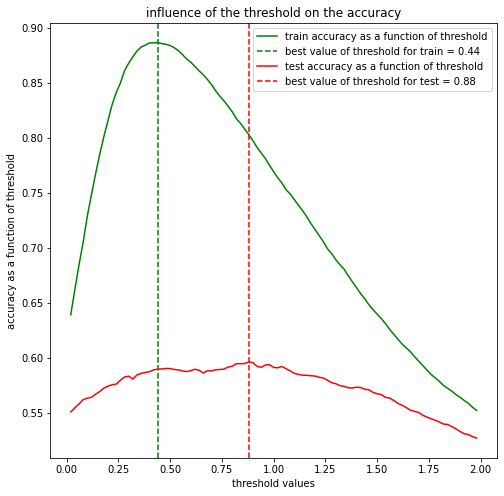

In [ ]:
best_train_threshold,best_test_threshold = threshold_plot(pred_test, y_test,pred_train, y_train2)

train and hard test set

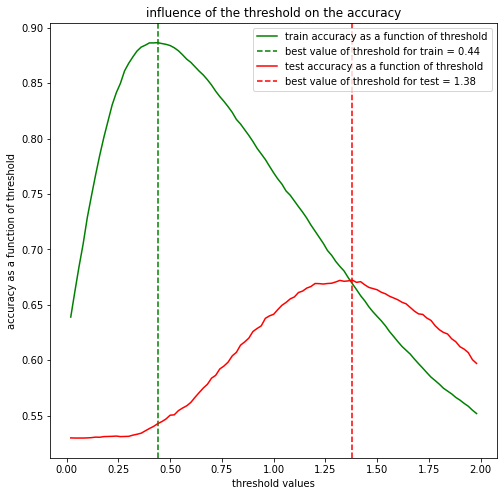

In [ ]:
best_train_threshold,best_test_threshold = threshold_plot(pred_test_hard, y_test_hard,pred_train, y_train2)


In [ ]:
acc_train = compute_accuracy(pred_train, y_train2,best_train_threshold)
acc_test = compute_accuracy(pred_test, y_test,best_test_threshold)
print('train accuracy of our best first model = ',acc_train)
print('test accuracy of our best first model = ',acc_test)
print('best threshold is ',best_test_threshold)

train accuracy of our best first model =  0.8864516129032258
test accuracy of our best first model =  0.5723529411764706
best threshold is  1.3800000000000001


train and easy test set 

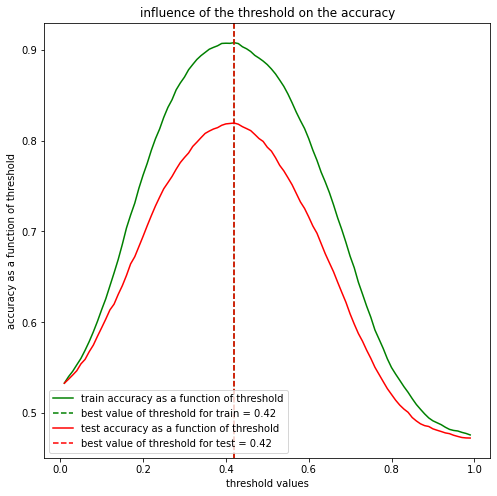

In [ ]:
best_train_threshold,best_test_threshold = threshold_plot(pred_test_easy, y_test_easy,pred_train, y_train)


# II- Binary cross entropy for one shot learning

### II-1 test without classes 5 to 9

In [24]:
### hyperparameters of the model
nb_epochs = 10
batch_size = 64

### model
input_shape = x_train.shape[1:4]

base_network_binary = tf.keras.models.clone_model(tmodel_modified)
base_network_binary.set_weights(tmodel_modified.get_weights()) 

# 2 parallel branches with the same weights of the same base network
branch1 = Input(input_shape)
branch2 = Input(input_shape)

processed1 = base_network_binary(branch1)
processed2 = base_network_binary(branch2)

###### what differs from contrastive loss setting, we add a fully connected layer and we use binary crossentropy
L1_distance = lambda x: K.abs(x[0]-x[1])

distance = Lambda(L1_distance, output_shape=lambda x: x[0])([processed1, processed2])

prediction = Dense(1,activation='sigmoid')(distance)
siamese_net = Model([branch1,branch2],prediction)


siamese_net.compile(loss='binary_crossentropy', optimizer='adam')
history_3 = siamese_net.fit([x_train[:,:,:,:, 0], x_train[:,:,:,:, 1]], y_train, batch_size=batch_size, epochs=nb_epochs, validation_split=0.2)

pred_train = siamese_net.predict([x_train[:,:,:,:,0], x_train[:,:,:,:,1]])

Epoch 1/10
107/107 [==============================] - 2s 21ms/step - loss: 0.8918 - val_loss: 0.7433
Epoch 2/10
107/107 [==============================] - 2s 16ms/step - loss: 0.7336 - val_loss: 0.6722
Epoch 3/10
107/107 [==============================] - 2s 16ms/step - loss: 0.6502 - val_loss: 0.5936
Epoch 4/10
107/107 [==============================] - 2s 16ms/step - loss: 0.5834 - val_loss: 0.5996
Epoch 5/10
107/107 [==============================] - 2s 16ms/step - loss: 0.5297 - val_loss: 0.5826
Epoch 6/10
107/107 [==============================] - 2s 16ms/step - loss: 0.4987 - val_loss: 0.5945
Epoch 7/10
107/107 [==============================] - 2s 16ms/step - loss: 0.4799 - val_loss: 0.5982
Epoch 8/10
107/107 [==============================] - 2s 16ms/step - loss: 0.4468 - val_loss: 0.5970
Epoch 9/10
107/107 [==============================] - 2s 16ms/step - loss: 0.4383 - val_loss: 0.6415
Epoch 10/10
107/107 [==============================] - 2s 16ms/step - loss: 0.4277 - val_lo

In [ ]:
acc = compute_accuracy2(pred_train, y_train,0.5)
print('train accuracy of our model = ',acc)

train accuracy of our model =  0.9490588235294117


accuracy on medium test

In [ ]:
pred_test = siamese_net.predict([x_test[:,:,:,:,0], x_test[:,:,:,:,1]])
acc_test = compute_accuracy2(pred_test, y_test,0.5)
print('Test accuracy of our model = ' ,acc_test)

Test accuracy of our model =  0.721764705882353


accuracy on easy test

In [ ]:
pred_test_easy = siamese_net.predict([x_test_easy[:,:,:,:,0], x_test_easy[:,:,:,:,1]])
acc_test_easy = compute_accuracy2(pred_test_easy, y_test_easy,0.5)
print('Test accuracy of our model = ' ,acc_test_easy)


Test accuracy of our model =  0.8211764705882353


accuracy on hard test set 

In [25]:
pred_test_hard = siamese_net.predict([x_test_hard[:,:,:,:,0], x_test_hard[:,:,:,:,1]])
acc_test_hard = compute_accuracy2(pred_test_hard, y_test_hard,0.5)
print('Test accuracy of our model = ' ,acc_test_hard)

Test accuracy of our model =  0.6696470588235294


### Influence of threshold¶


train and medium set



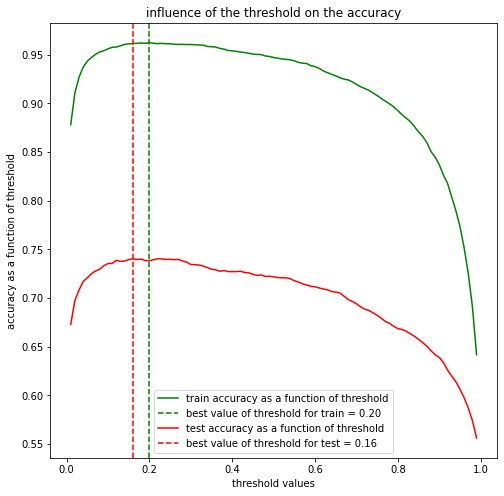

In [ ]:
best_train_threshold,best_test_threshold = threshold_plot2(pred_test,y_test,pred_train, y_train)

train and hard set

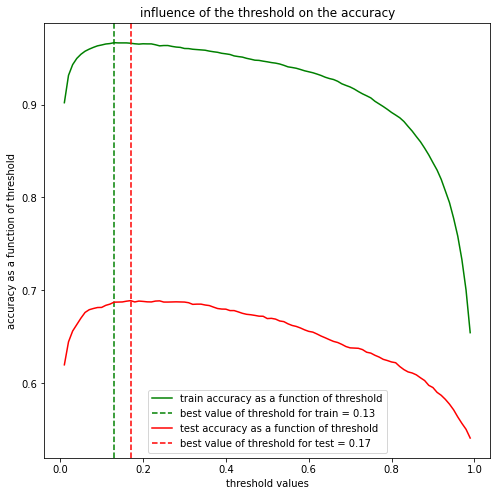

In [26]:
best_train_threshold,best_test_threshold = threshold_plot2(pred_test_hard, y_test_hard,pred_train, y_train)


train and easy test set

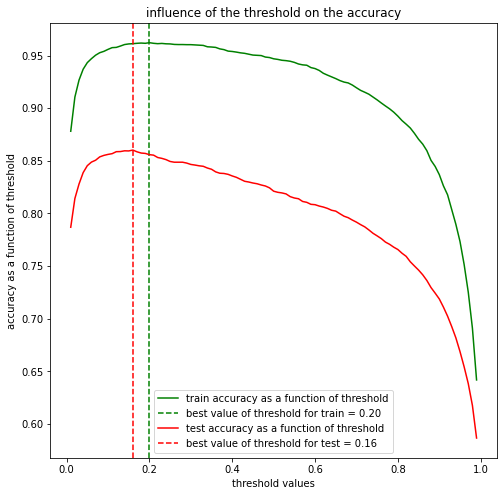

In [ ]:
best_train_threshold,best_test_threshold = threshold_plot2(pred_test_easy, y_test_easy,pred_train, y_train)


### II-2 test with classes 5 to 9

In [41]:
### hyperparameters of the model
nb_epochs = 10
batch_size = 64

### model
input_shape = x_train2.shape[1:4]
base_network_binary2 = tf.keras.models.clone_model(tmodel_modified)
base_network_binary2.set_weights(tmodel_modified.get_weights()) 

# 2 parallel branches with the same weights of the same base network
branch1 = Input(input_shape)
branch2 = Input(input_shape)

processed1 = base_network_binary2(branch1)
processed2 = base_network_binary2(branch2)

###### what differs from contrastive loss setting, we add a fully connected layer and we use binary crossentropy
L1_distance = lambda x: K.abs(x[0]-x[1])

distance = Lambda(L1_distance, output_shape=lambda x: x[0])([processed1, processed2])

prediction = Dense(1,activation='sigmoid')(distance)
siamese_net = Model([branch1,branch2],prediction)


siamese_net.compile(loss='binary_crossentropy', optimizer='adam')
history_4 = siamese_net.fit([x_train2[:,:,:,:, 0], x_train2[:,:,:,:, 1]], y_train2, batch_size=batch_size, epochs=nb_epochs, validation_split =0.2)

pred_train = siamese_net.predict([x_train2[:,:,:,:,0], x_train2[:,:,:,:,1]])

Epoch 1/10
94/94 [==============================] - 2s 20ms/step - loss: 0.8050 - val_loss: 0.7090
Epoch 2/10
94/94 [==============================] - 2s 16ms/step - loss: 0.6733 - val_loss: 0.6637
Epoch 3/10
94/94 [==============================] - 2s 16ms/step - loss: 0.5988 - val_loss: 0.6192
Epoch 4/10
94/94 [==============================] - 2s 16ms/step - loss: 0.5296 - val_loss: 0.6053
Epoch 5/10
94/94 [==============================] - 2s 16ms/step - loss: 0.4923 - val_loss: 0.5889
Epoch 6/10
94/94 [==============================] - 2s 16ms/step - loss: 0.4693 - val_loss: 0.5698
Epoch 7/10
94/94 [==============================] - 2s 16ms/step - loss: 0.4359 - val_loss: 0.6419
Epoch 8/10
94/94 [==============================] - 2s 16ms/step - loss: 0.4080 - val_loss: 0.5751
Epoch 9/10
94/94 [==============================] - 2s 16ms/step - loss: 0.4065 - val_loss: 0.5404
Epoch 10/10
94/94 [==============================] - 2s 16ms/step - loss: 0.3814 - val_loss: 0.6259


In [ ]:
acc = compute_accuracy2(pred_train, y_train2,0.2)
print('train accuracy of our model = ',acc)

train accuracy of our model =  0.9513333333333334


accuracy on medium test set

In [38]:
pred_test = siamese_net.predict([x_test[:,:,:,:,0], x_test[:,:,:,:,1]])
acc_test = compute_accuracy2(pred_test, y_test,0.2)
print('Test accuracy of our model = ' ,acc_test)

Test accuracy of our model =  0.6994117647058824


accuracy on easy test set

In [ ]:

pred_test_easy = siamese_net.predict([x_test_easy[:,:,:,:,0], x_test_easy[:,:,:,:,1]])
acc_test_easy = compute_accuracy2(pred_test_easy, y_test_easy,0.5)
print('Test accuracy of our model = ' ,acc_test_easy)

Test accuracy of our model =  0.766235294117647


accuracy on hard test set

In [31]:

pred_test_hard = siamese_net.predict([x_test_hard[:,:,:,:,0], x_test_hard[:,:,:,:,1]])
acc_test_hard = compute_accuracy2(pred_test_hard, y_test_hard,0.5)
print('Test accuracy of our model = ' ,acc_test_hard)

Test accuracy of our model =  0.584


## Impact of the threshold

train and medium test set

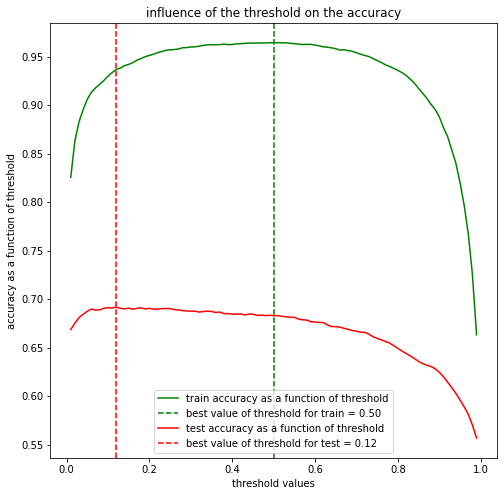

In [ ]:
best_train_threshold,best_test_threshold = threshold_plot2(pred_test,y_test,pred_train, y_train2)

train and easy test set

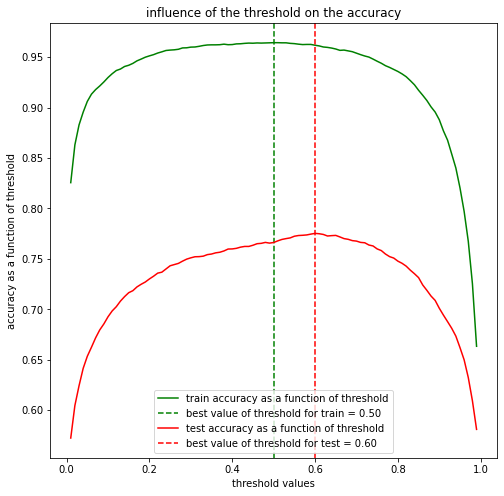

In [ ]:
best_train_threshold,best_test_threshold = threshold_plot2(pred_test_easy, y_test_easy,pred_train, y_train2)


train and hard test set

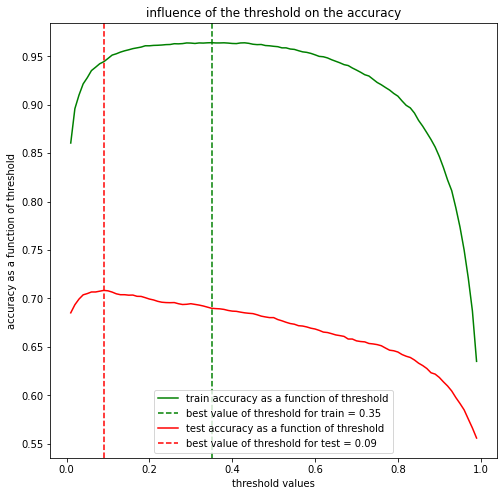

In [39]:
best_train_threshold,best_test_threshold = threshold_plot2(pred_test_hard,y_test_hard,pred_train, y_train2)

### Comparison between the loss of the contrastive model and the binary cross entropy Model


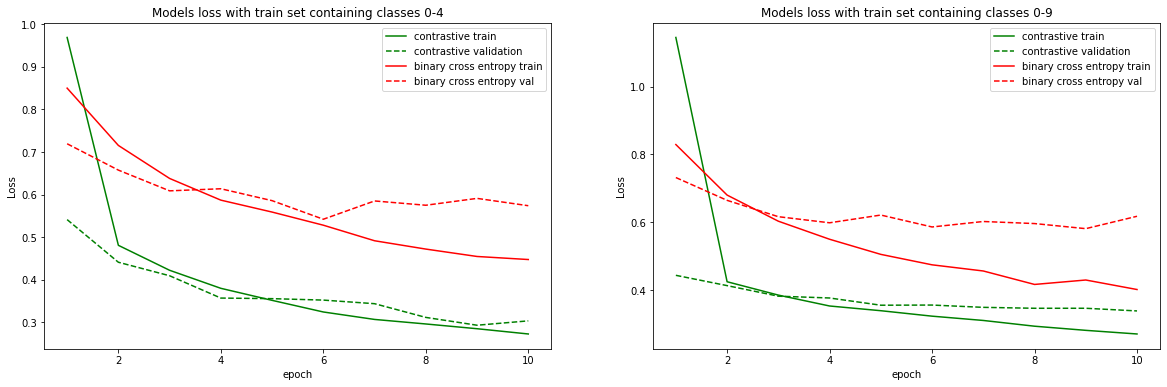

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(121)
loss_comparison_plot(history,history_3)
plt.title('Models loss with train set containing classes 0-4')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.subplot(122)
loss_comparison_plot(history2,history_4)
plt.title('Models loss with train set containing classes 0-9')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

## III- Triplet Loss : 


### III-1- Random choice of triplets , train only on classes 0 to 4 :

### III-1-1 Prepare the data

In [42]:
x = np.concatenate([all_train[0],all_train[1],all_train[2],all_train[3],all_train[4]],axis = 0)
y = np.array([0]*all_train[0].shape[0]+[1]*all_train[1].shape[0]+[2]*all_train[2].shape[0]+[3]*all_train[3].shape[0]+[4]*all_train[4].shape[0])

In [43]:
x,y = shuffle(x, y, random_state=0)

In [44]:
X_train, _ = generate_triplet(x,y, ap_pairs=50, an_pairs=60,testsize=0)


In [45]:
test_labels=(test_labels.reshape(test_labels.shape[0],))

In [46]:
_, X_test = generate_triplet(test_images,test_labels, ap_pairs=50, an_pairs=30,testsize=1)

In [47]:
X_train = shuffle(X_train, random_state=0)
X_test = shuffle(X_test, random_state=0)

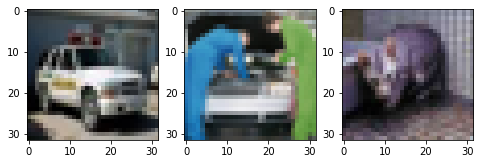

In [ ]:
fig=plt.figure(figsize=(8, 8))
index = random.randint(0,2400)
fig.add_subplot(1,3,1)
plt.imshow(X_train[index,0,:].reshape(32,32,3))
fig.add_subplot(1,3,2)
plt.imshow(X_train[index,1,:].reshape(32,32,3))
fig.add_subplot(1,3,3)
plt.imshow(X_train[index,2,:].reshape(32,32,3))

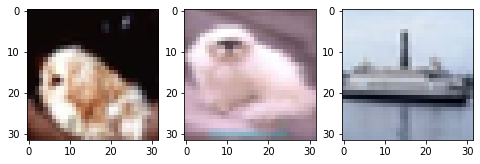

In [ ]:
fig=plt.figure(figsize=(8, 8))
index = random.randint(0,2400)
fig.add_subplot(1,3,1)
plt.imshow(X_test[index,0,:].reshape(32,32,3))
fig.add_subplot(1,3,2)
plt.imshow(X_test[index,1,:].reshape(32,32,3))
fig.add_subplot(1,3,3)
plt.imshow(X_test[index,2,:].reshape(32,32,3))

#### III-1- 2- Build the model and train It 

In [48]:
adam_optim = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999)
anchor_input = Input((32,32,3, ), name='anchor_input')
positive_input = Input((32,32,3, ), name='positive_input')
negative_input = Input((32,32,3, ), name='negative_input')

# Shared embedding layer for positive and negative items
Shared_DNN = tf.keras.models.clone_model(tmodel_modified)
Shared_DNN.set_weights(tmodel_modified.get_weights()) 

encoded_anchor = Shared_DNN(anchor_input)
encoded_positive = Shared_DNN(positive_input)
encoded_negative = Shared_DNN(negative_input)


merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

model_triplet = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model_triplet.compile(loss=triplet_loss, optimizer=adam_optim)

In [ ]:
model_triplet.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128)          549280      anchor_input[0][0]               
                                                                 positive_input[0][0]  

In [49]:
Anchor = X_train[:,0,:].reshape(-1,32,32,3)
Positive = X_train[:,1,:].reshape(-1,32,32,3)
Negative = X_train[:,2,:].reshape(-1,32,32,3)
Anchor_test = X_test[:,0,:].reshape(-1,32,32,3)
Positive_test = X_test[:,1,:].reshape(-1,32,32,3)
Negative_test = X_test[:,2,:].reshape(-1,32,32,3)

Y_dummy = np.empty((Anchor.shape[0],300)) ## Vector that is not used in training
Y_dummy2 = np.empty((Anchor_test.shape[0],1)) ## Vector that is not used in training

history_random = model_triplet.fit([Anchor,Positive,Negative],y=Y_dummy,validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2), batch_size=60, epochs=20)

Epoch 1/20
y_pred.shape =  Tensor("functional_9/merged_layer/concat:0", shape=(60, 384), dtype=float32)
y_pred.shape =  Tensor("functional_9/merged_layer/concat:0", shape=(60, 384), dtype=float32)
250/250 [==============================] - 7s 27ms/step - loss: 2.9315 - val_loss: 2.0226
Epoch 2/20
250/250 [==============================] - 6s 26ms/step - loss: 2.1435 - val_loss: 1.8981
Epoch 3/20
250/250 [==============================] - 6s 26ms/step - loss: 1.6979 - val_loss: 1.7971
Epoch 4/20
250/250 [==============================] - 6s 26ms/step - loss: 1.3521 - val_loss: 1.7417
Epoch 5/20
250/250 [==============================] - 6s 26ms/step - loss: 1.1537 - val_loss: 1.6843
Epoch 6/20
250/250 [==============================] - 6s 26ms/step - loss: 1.0265 - val_loss: 1.6373
Epoch 7/20
250/250 [==============================] - 6s 25ms/step - loss: 0.8886 - val_loss: 1.5965
Epoch 8/20
250/250 [==============================] - 6s 25ms/step - loss: 0.8225 - val_loss: 1.5462
Epoch 

### III-1-3- Impact of the threshold on the accuracy

In [60]:
distances = []

encod1 = Shared_DNN.predict(x_test_easy.reshape(-1,32,32,2)[:,:,:,0].reshape(-1,32,32,3))
encod2 = Shared_DNN.predict(x_test_easy.reshape(-1,32,32,2)[:,:,:,1].reshape(-1,32,32,3))

distances.append(np.array(euclidean_distance((encod1, encod2))))

encod1 = Shared_DNN.predict(x_test.reshape(-1,32,32,2)[:,:,:,0].reshape(-1,32,32,3))
encod2 = Shared_DNN.predict(x_test.reshape(-1,32,32,2)[:,:,:,1].reshape(-1,32,32,3))

distances.append(np.array(euclidean_distance((encod1, encod2))))

encod1 = Shared_DNN.predict(x_test_hard.reshape(-1,32,32,2)[:,:,:,0].reshape(-1,32,32,3))
encod2 = Shared_DNN.predict(x_test_hard.reshape(-1,32,32,2)[:,:,:,1].reshape(-1,32,32,3))

distances.append(np.array(euclidean_distance((encod1, encod2))))

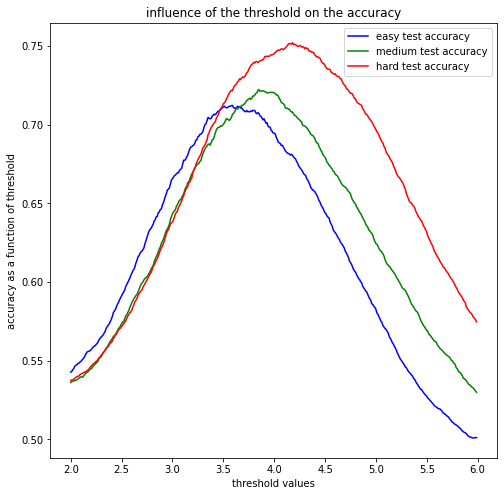

In [62]:
acc_list = []
y = [y_train, y_test_easy,y_test,y_test_hard]
threshold_list = [i*0.01 for i in range (200,600)]
for i in range(len(distances)):
  acc_list.append([compute_accuracy(distances[i], y[i],threshold) for threshold in threshold_list])

plt.figure(figsize = (8,8))
plt.plot(threshold_list,acc_list[0],label='easy test accuracy', c='blue')
plt.plot(threshold_list,acc_list[1],label='medium test accuracy', c='green')
plt.plot(threshold_list,acc_list[2],label='hard test accuracy', c='red')
plt.xlabel('threshold values')
plt.ylabel('accuracy as a function of threshold')
plt.title('influence of the threshold on the accuracy')
plt.legend()
plt.show()

### IV- Comparison of all the three models trained only on classes 0 to 4

In [ ]:
number_of_processes = 20
size_of_encoding_triplet = 128
size_of_encoding_contrastive = 128
size_of_encoding_binary = 128
acc1 = n_way_one_shotlearning (Shared_DNN, all_train,all_test, number_of_processes , 'triplet',size_of_encoding_triplet)
acc2 = n_way_one_shotlearning (base_network_contrastive, all_train,all_test, number_of_processes , 'contrastive',size_of_encoding_contrastive)
acc3 = n_way_one_shotlearning (base_network_binary, all_train,all_test, number_of_processes , 'binary_crossentropy',size_of_encoding_binary)

In [ ]:
acc1[-1], acc2[-1], acc3[-1]

(0.25, 0.4, 0.35)

a- Comparison of the accuracy on the medium dataset

In [ ]:
number_of_processes = 20
size_of_encoding_triplet = 128
size_of_encoding_contrastive = 128
size_of_encoding_binary = 128

nb = np.arange(10,80,1)
acc_triplet = []
acc_binary = []
acc_contrastive = []
for number_of_processes in nb:
  acc1 = n_way_one_shotlearning (Shared_DNN, all_train,all_test, number_of_processes ,
                                 'triplet',size_of_encoding_triplet,'medium')
  acc2 = n_way_one_shotlearning (base_network_contrastive1, all_train,all_test, number_of_processes ,
                                 'contrastive',size_of_encoding_contrastive,'medium')
  acc3 = n_way_one_shotlearning (base_network_binary, all_train,all_test, number_of_processes , 
                                 'binary_crossentropy',size_of_encoding_binary,'medium')
  acc_triplet.append(acc1[1])
  acc_contrastive.append(acc2[1])
  acc_binary.append(acc3[1])

In [ ]:
np.mean(acc_triplet), np.mean(acc_contrastive), np.mean(acc_binary)

(0.5806045490592318, 0.38755119605224897, 0.44529875121490053)

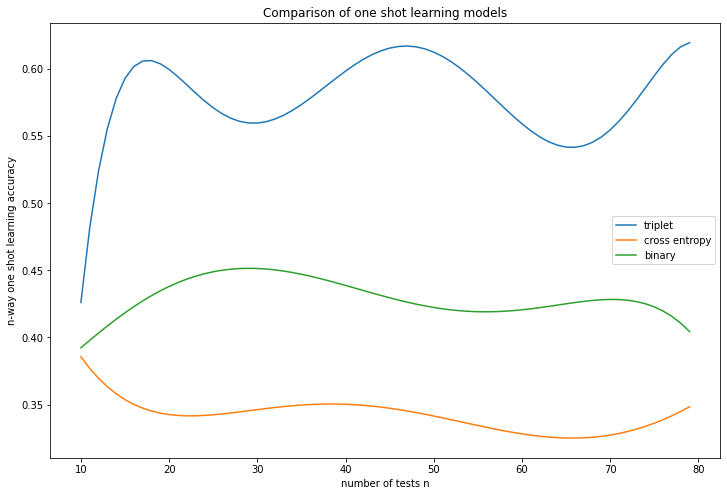

In [ ]:
plt.figure(figsize=(12,8))
poly = np.polyfit(nb,acc_triplet,6)
poly_y1 = np.poly1d(poly)(nb)
poly = np.polyfit(nb,acc_contrastive,5)
poly_y2 = np.poly1d(poly)(nb)
poly = np.polyfit(nb,acc_binary,5)
poly_y3 = np.poly1d(poly)(nb)
plt.plot(nb,poly_y1,label='triplet')
plt.plot(nb,poly_y2,label='cross entropy')
plt.plot(nb,poly_y3,label='binary')
plt.xlabel('number of tests n')
plt.ylabel('n-way one shot learning accuracy')
plt.title('Comparison of one shot learning models')
plt.legend()
plt.show()


b- Comparison of the accuracy on the hard dataset

In [ ]:
nb = np.arange(10,40,1)
acc_triplet = []
acc_binary = []
acc_contrastive = []
for number_of_processes in nb:
  acc1 = n_way_one_shotlearning (Shared_DNN, all_train,all_test, number_of_processes ,
                                 'triplet',size_of_encoding_triplet,'hard')
  acc2 = n_way_one_shotlearning (base_network_contrastive1, all_train,all_test, number_of_processes ,
                                 'contrastive',size_of_encoding_contrastive,'hard')
  acc3 = n_way_one_shotlearning (base_network_binary, all_train,all_test, number_of_processes , 
                                 'binary_crossentropy',size_of_encoding_binary,'hard')
  acc_triplet.append(acc1[1])
  acc_contrastive.append(acc2[1])
  acc_binary.append(acc3[1])

In [ ]:
np.mean(acc_triplet), np.mean(acc_contrastive), np.mean(acc_binary)

(0.6149860228810322, 0.28859889122370025, 0.39045241840227685)

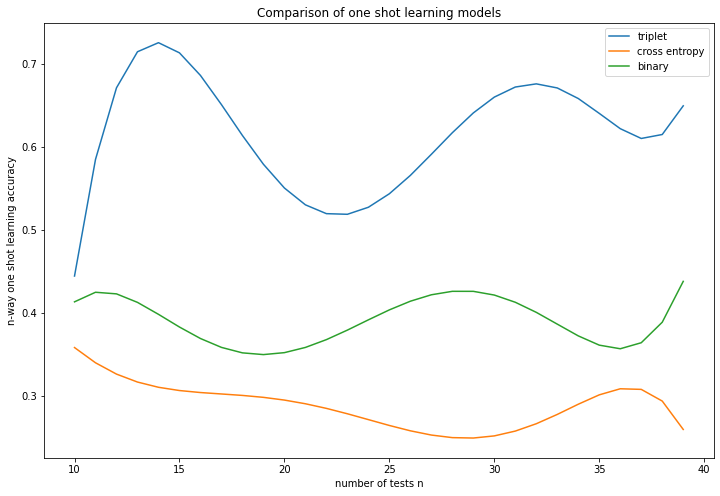

In [ ]:
plt.figure(figsize=(12,8))
poly = np.polyfit(nb,acc_triplet,6)
poly_y1 = np.poly1d(poly)(nb)
poly = np.polyfit(nb,acc_contrastive,6)
poly_y2 = np.poly1d(poly)(nb)
poly = np.polyfit(nb,acc_binary,5)
poly_y3 = np.poly1d(poly)(nb)
plt.plot(nb,poly_y1,label='triplet')
plt.plot(nb,poly_y2,label='cross entropy')
plt.plot(nb,poly_y3,label='binary')
plt.xlabel('number of tests n')
plt.ylabel('n-way one shot learning accuracy')
plt.title('Comparison of one shot learning models')
plt.legend()
plt.show()

### Triplet loss : Impact of the choice of the triplets

find easy triplets, hard triplets, and semi hard triplets

In [63]:
def triplet_type(X_train,margin): 
  easy_triplet=[]
  hard_triplet=[]
  semihard_triplet=[]
  random_triplet=[]
  for j in range(X_train.shape[0]):
    A=X_train[j,0,:]
    P=X_train[j,1,:]
    N=X_train[j,2,:]
    d_AP=euclidean_distance2(A,P).numpy()
    d_AN=euclidean_distance2(A,N).numpy()
    if d_AP + margin < d_AN: #easy triplet
      easy_triplet.append([A,P,N]) 
    elif d_AN < d_AP: #hard triplet
      hard_triplet.append([A,P,N])
    elif (d_AP < d_AN and d_AN < d_AP + margin): #semi hard triplet
      semihard_triplet.append([A,P,N])
    else:
      random_triplet.append([A,P,N])

  return (np.array(easy_triplet),np.array(hard_triplet),np.array(semihard_triplet),np.array(random_triplet))

In [64]:

def euclidean_distance2(x,y):
  sum_square = K.sum(K.square(x - y), axis=0, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [65]:
easy_triplet_train,hard_triplet_train,semihard_triplet_train,random_triplet_train=triplet_type(X_train,0.001)


In [ ]:
X_train.shape[0], easy_triplet_train.shape[0], hard_triplet_train.shape[0], semihard_triplet_train.shape[0]


(15000, 7603, 7395, 2)

choose train sets : random , easy and hard of same size 



In [66]:

indexes = np.random.randint(X_train.shape[0], size=5000)
X_train2 = X_train[indexes,:]

In [67]:

indexes = np.random.randint(easy_triplet_train.shape[0], size=5000)
easy_triplet_train = easy_triplet_train[indexes,:]

In [68]:
indexes = np.random.randint(hard_triplet_train.shape[0], size=5000)
hard_triplet_train = hard_triplet_train[indexes,:]

In [69]:
indexes = np.random.randint(X_test.shape[0], size=1000)
X_test2 = X_test[indexes,:]

1- train only on hard triplets 

In [70]:
adam_optim = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999)
anchor_input = Input((32,32,3, ), name='anchor_input')
positive_input = Input((32,32,3, ), name='positive_input')
negative_input = Input((32,32,3, ), name='negative_input')

# Shared embedding layer for positive and negative items

Shared_DNN_hard = tf.keras.models.clone_model(tmodel_modified)
Shared_DNN_hard.set_weights(tmodel_modified.get_weights()) 

encoded_anchor = Shared_DNN_hard(anchor_input)
encoded_positive = Shared_DNN_hard(positive_input)
encoded_negative = Shared_DNN_hard(negative_input)


merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

In [71]:
Anchor_hard = hard_triplet_train[:,0,:].reshape(-1,32,32,3)
Positive_hard = hard_triplet_train[:,1,:].reshape(-1,32,32,3)
Negative_hard = hard_triplet_train[:,2,:].reshape(-1,32,32,3)
Anchor_test = X_test2[:,0,:].reshape(-1,32,32,3)
Positive_test = X_test2[:,1,:].reshape(-1,32,32,3)
Negative_test = X_test2[:,2,:].reshape(-1,32,32,3)

Y_dummy = np.empty((Anchor_hard.shape[0],300)) ## Vector that is not used in training
Y_dummy2 = np.empty((Anchor_test.shape[0],1)) ## Vector that is not used in training

In [72]:
n_epochs = 40
batch_size = 20
model_triplet_hard = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model_triplet_hard.compile(loss=triplet_loss, optimizer=adam_optim)
history_hard = model_triplet_hard.fit([Anchor_hard,Positive_hard,Negative_hard],y=Y_dummy,validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2), batch_size=batch_size, epochs=n_epochs)

Epoch 1/40
y_pred.shape =  Tensor("functional_11/merged_layer/concat:0", shape=(20, 384), dtype=float32)
y_pred.shape =  Tensor("functional_11/merged_layer/concat:0", shape=(20, 384), dtype=float32)
250/250 [==============================] - 3s 12ms/step - loss: 2.5477 - val_loss: 2.1629
Epoch 2/40
250/250 [==============================] - 3s 10ms/step - loss: 2.0378 - val_loss: 2.0928
Epoch 3/40
250/250 [==============================] - 3s 11ms/step - loss: 1.7902 - val_loss: 2.0402
Epoch 4/40
250/250 [==============================] - 3s 11ms/step - loss: 1.5014 - val_loss: 2.0241
Epoch 5/40
250/250 [==============================] - 3s 11ms/step - loss: 1.3390 - val_loss: 1.9859
Epoch 6/40
250/250 [==============================] - 3s 11ms/step - loss: 1.2233 - val_loss: 1.9568
Epoch 7/40
250/250 [==============================] - 3s 10ms/step - loss: 1.0459 - val_loss: 1.9367
Epoch 8/40
250/250 [==============================] - 3s 11ms/step - loss: 0.9701 - val_loss: 1.9219
Epoc

In [73]:
distances = []

encod1 = Shared_DNN_hard.predict(x_test_easy.reshape(-1,32,32,2)[:,:,:,0].reshape(-1,32,32,3))
encod2 = Shared_DNN_hard.predict(x_test_easy.reshape(-1,32,32,2)[:,:,:,1].reshape(-1,32,32,3))

distances.append(np.array(euclidean_distance((encod1, encod2))))

encod1 = Shared_DNN_hard.predict(x_test.reshape(-1,32,32,2)[:,:,:,0].reshape(-1,32,32,3))
encod2 = Shared_DNN_hard.predict(x_test.reshape(-1,32,32,2)[:,:,:,1].reshape(-1,32,32,3))

distances.append(np.array(euclidean_distance((encod1, encod2))))

encod1 = Shared_DNN_hard.predict(x_test_hard.reshape(-1,32,32,2)[:,:,:,0].reshape(-1,32,32,3))
encod2 = Shared_DNN_hard.predict(x_test_hard.reshape(-1,32,32,2)[:,:,:,1].reshape(-1,32,32,3))

distances.append(np.array(euclidean_distance((encod1, encod2))))

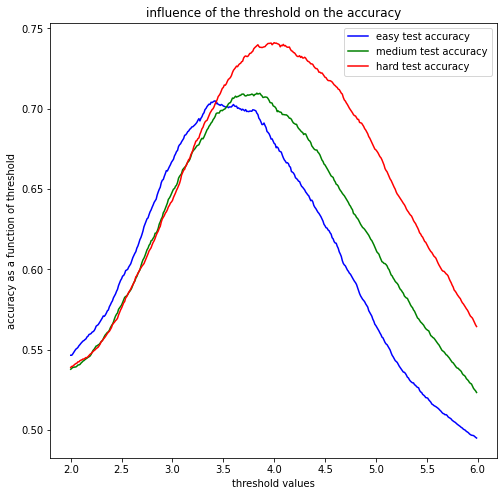

In [74]:
acc_list = []
y = [y_train, y_test_easy,y_test,y_test_hard]
threshold_list = [i*0.01 for i in range (200,600)]
for i in range(len(distances)):
  acc_list.append([compute_accuracy(distances[i], y[i],threshold) for threshold in threshold_list])

plt.figure(figsize = (8,8))
plt.plot(threshold_list,acc_list[0],label='easy test accuracy', c='blue')
plt.plot(threshold_list,acc_list[1],label='medium test accuracy', c='green')
plt.plot(threshold_list,acc_list[2],label='hard test accuracy', c='red')
plt.xlabel('threshold values')
plt.ylabel('accuracy as a function of threshold')
plt.title('influence of the threshold on the accuracy')
plt.legend()
plt.show()

2- train the model using only easy triplets

In [75]:

adam_optim = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999)
anchor_input = Input((32,32,3, ), name='anchor_input')
positive_input = Input((32,32,3, ), name='positive_input')
negative_input = Input((32,32,3, ), name='negative_input')

# Shared embedding layer for positive and negative items

Shared_DNN_easy = tf.keras.models.clone_model(tmodel_modified)
Shared_DNN_easy.set_weights(tmodel_modified.get_weights()) 

encoded_anchor = Shared_DNN_easy(anchor_input)
encoded_positive = Shared_DNN_easy(positive_input)
encoded_negative = Shared_DNN_easy(negative_input)


merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

In [76]:
Anchor_easy = easy_triplet_train[:,0,:].reshape(-1,32,32,3)
Positive_easy = easy_triplet_train[:,1,:].reshape(-1,32,32,3)
Negative_easy = easy_triplet_train[:,2,:].reshape(-1,32,32,3)
Anchor_test = X_test[:,0,:].reshape(-1,32,32,3)
Positive_test = X_test[:,1,:].reshape(-1,32,32,3)
Negative_test = X_test[:,2,:].reshape(-1,32,32,3)

Y_dummy = np.empty((Anchor_easy.shape[0],300)) ## Vector that is not used in training
Y_dummy2 = np.empty((Anchor_test.shape[0],1)) ## Vector that is not used in training

model_triplet_easy = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model_triplet_easy.compile(loss=triplet_loss, optimizer=adam_optim)
history_easy= model_triplet_easy.fit([Anchor_easy,Positive_easy,Negative_easy],y=Y_dummy,validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2), batch_size=batch_size, epochs=n_epochs)

Epoch 1/40
y_pred.shape =  Tensor("functional_13/merged_layer/concat:0", shape=(20, 384), dtype=float32)
y_pred.shape =  Tensor("functional_13/merged_layer/concat:0", shape=(20, 384), dtype=float32)
250/250 [==============================] - 6s 24ms/step - loss: 2.9422 - val_loss: 2.1422
Epoch 2/40
250/250 [==============================] - 5s 21ms/step - loss: 2.4068 - val_loss: 2.0437
Epoch 3/40
250/250 [==============================] - 5s 20ms/step - loss: 2.0403 - val_loss: 1.9436
Epoch 4/40
250/250 [==============================] - 5s 20ms/step - loss: 1.6613 - val_loss: 1.8937
Epoch 5/40
250/250 [==============================] - 5s 20ms/step - loss: 1.4339 - val_loss: 1.8347
Epoch 6/40
250/250 [==============================] - 5s 20ms/step - loss: 1.3138 - val_loss: 1.7959
Epoch 7/40
250/250 [==============================] - 5s 20ms/step - loss: 1.1496 - val_loss: 1.7463
Epoch 8/40
250/250 [==============================] - 5s 20ms/step - loss: 1.0797 - val_loss: 1.7058
Epoc

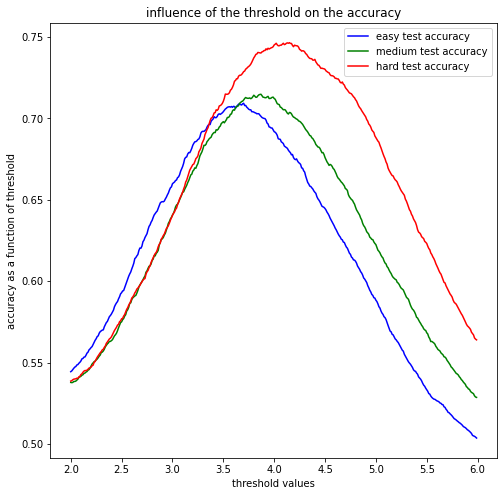

In [77]:
distances = []

encod1 = Shared_DNN_easy.predict(x_test_easy.reshape(-1,32,32,2)[:,:,:,0].reshape(-1,32,32,3))
encod2 = Shared_DNN_easy.predict(x_test_easy.reshape(-1,32,32,2)[:,:,:,1].reshape(-1,32,32,3))

distances.append(np.array(euclidean_distance((encod1, encod2))))

encod1 = Shared_DNN_easy.predict(x_test.reshape(-1,32,32,2)[:,:,:,0].reshape(-1,32,32,3))
encod2 = Shared_DNN_easy.predict(x_test.reshape(-1,32,32,2)[:,:,:,1].reshape(-1,32,32,3))

distances.append(np.array(euclidean_distance((encod1, encod2))))

encod1 = Shared_DNN_easy.predict(x_test_hard.reshape(-1,32,32,2)[:,:,:,0].reshape(-1,32,32,3))
encod2 = Shared_DNN_easy.predict(x_test_hard.reshape(-1,32,32,2)[:,:,:,1].reshape(-1,32,32,3))

distances.append(np.array(euclidean_distance((encod1, encod2))))

acc_list = []
y = [y_train, y_test_easy,y_test,y_test_hard]
threshold_list = [i*0.01 for i in range (200,600)]
for i in range(len(distances)):
  acc_list.append([compute_accuracy(distances[i], y[i],threshold) for threshold in threshold_list])

plt.figure(figsize = (8,8))
plt.plot(threshold_list,acc_list[0],label='easy test accuracy', c='blue')
plt.plot(threshold_list,acc_list[1],label='medium test accuracy', c='green')
plt.plot(threshold_list,acc_list[2],label='hard test accuracy', c='red')
plt.xlabel('threshold values')
plt.ylabel('accuracy as a function of threshold')
plt.title('influence of the threshold on the accuracy')
plt.legend()
plt.show()

3- Train using random triplets

In [78]:
adam_optim = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999)
anchor_input = Input((32,32,3, ), name='anchor_input')
positive_input = Input((32,32,3, ), name='positive_input')
negative_input = Input((32,32,3, ), name='negative_input')

# Shared embedding layer for positive and negative items

Shared_DNN_random = tf.keras.models.clone_model(tmodel_modified)
Shared_DNN_random.set_weights(tmodel_modified.get_weights()) 

encoded_anchor = Shared_DNN_random(anchor_input)
encoded_positive = Shared_DNN_random(positive_input)
encoded_negative = Shared_DNN_random(negative_input)


merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

In [79]:
n_epochs = 40
Anchor_random = X_train2[:,0,:].reshape(-1,32,32,3)
Positive_random = X_train2[:,1,:].reshape(-1,32,32,3)
Negative_random = X_train2[:,2,:].reshape(-1,32,32,3)
Anchor_test = X_test[:,0,:].reshape(-1,32,32,3)
Positive_test = X_test[:,1,:].reshape(-1,32,32,3)
Negative_test = X_test[:,2,:].reshape(-1,32,32,3)
batch_size = 20

Y_dummy = np.empty((Anchor_random.shape[0],300)) ## Vector that is not used in training
Y_dummy2 = np.empty((Anchor_test.shape[0],1)) ## Vector that is not used in training

model_triplet_random= Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model_triplet_random.compile(loss=triplet_loss, optimizer=adam_optim)
history_random = model_triplet_random.fit([Anchor_random,Positive_random,Negative_random],y=Y_dummy,validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2), batch_size=batch_size, epochs=n_epochs)

Epoch 1/40
y_pred.shape =  Tensor("functional_15/merged_layer/concat:0", shape=(20, 384), dtype=float32)
y_pred.shape =  Tensor("functional_15/merged_layer/concat:0", shape=(20, 384), dtype=float32)
250/250 [==============================] - 6s 23ms/step - loss: 2.8471 - val_loss: 2.1109
Epoch 2/40
250/250 [==============================] - 5s 20ms/step - loss: 2.4263 - val_loss: 1.9916
Epoch 3/40
250/250 [==============================] - 5s 20ms/step - loss: 2.1229 - val_loss: 1.9274
Epoch 4/40
250/250 [==============================] - 5s 20ms/step - loss: 1.7790 - val_loss: 1.8818
Epoch 5/40
250/250 [==============================] - 5s 20ms/step - loss: 1.5956 - val_loss: 1.8223
Epoch 6/40
250/250 [==============================] - 5s 20ms/step - loss: 1.3727 - val_loss: 1.7823
Epoch 7/40
250/250 [==============================] - 5s 20ms/step - loss: 1.2506 - val_loss: 1.7266
Epoch 8/40
250/250 [==============================] - 5s 20ms/step - loss: 1.1214 - val_loss: 1.7119
Epoc

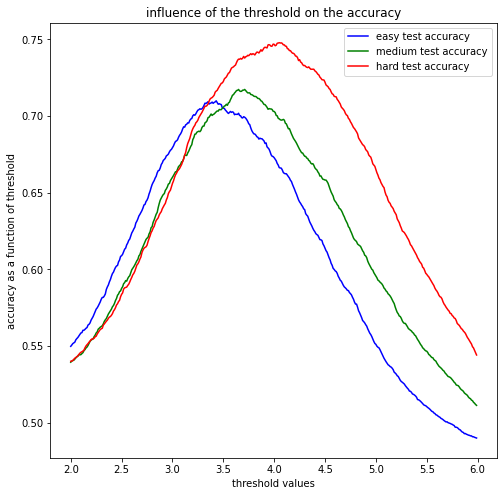

In [80]:
distances = []

encod1 = Shared_DNN_random.predict(x_test_easy.reshape(-1,32,32,2)[:,:,:,0].reshape(-1,32,32,3))
encod2 = Shared_DNN_random.predict(x_test_easy.reshape(-1,32,32,2)[:,:,:,1].reshape(-1,32,32,3))

distances.append(np.array(euclidean_distance((encod1, encod2))))

encod1 = Shared_DNN_random.predict(x_test.reshape(-1,32,32,2)[:,:,:,0].reshape(-1,32,32,3))
encod2 = Shared_DNN_random.predict(x_test.reshape(-1,32,32,2)[:,:,:,1].reshape(-1,32,32,3))

distances.append(np.array(euclidean_distance((encod1, encod2))))

encod1 = Shared_DNN_random.predict(x_test_hard.reshape(-1,32,32,2)[:,:,:,0].reshape(-1,32,32,3))
encod2 = Shared_DNN_random.predict(x_test_hard.reshape(-1,32,32,2)[:,:,:,1].reshape(-1,32,32,3))

distances.append(np.array(euclidean_distance((encod1, encod2))))

acc_list = []
y = [y_train, y_test_easy,y_test,y_test_hard]
threshold_list = [i*0.01 for i in range (200,600)]
for i in range(len(distances)):
  acc_list.append([compute_accuracy(distances[i], y[i],threshold) for threshold in threshold_list])

plt.figure(figsize = (8,8))
plt.plot(threshold_list,acc_list[0],label='easy test accuracy', c='blue')
plt.plot(threshold_list,acc_list[1],label='medium test accuracy', c='green')
plt.plot(threshold_list,acc_list[2],label='hard test accuracy', c='red')
plt.xlabel('threshold values')
plt.ylabel('accuracy as a function of threshold')
plt.title('influence of the threshold on the accuracy')
plt.legend()
plt.show()

3- compare the three approaches (random, hard and easy)

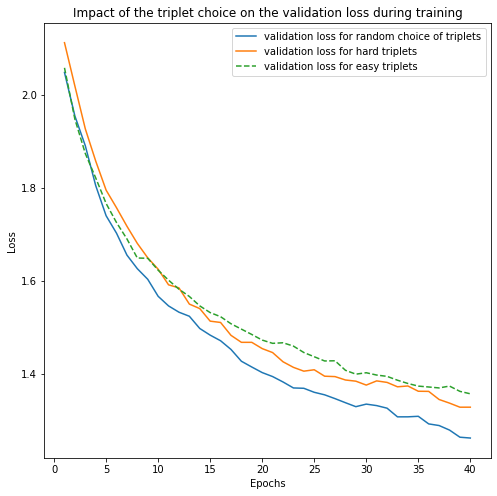

In [ ]:

plt.figure(figsize=(8, 8))
history_dict1 = history_random.history
history_dict2 = history_hard.history
history_dict3 = history_easy.history

loss_values1 = history_dict1['val_loss']
loss_values2 = history_dict2['val_loss']
loss_values3 = history_dict3['val_loss']

epochs = range(1, len(loss_values1) + 1)
plt.plot(epochs, loss_values1, label='validation loss for random choice of triplets')
plt.plot(epochs, loss_values2, label='validation loss for hard triplets')
plt.plot(epochs, loss_values3, label='validation loss for easy triplets', linestyle='--')
plt.title('Impact of the triplet choice on the validation loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

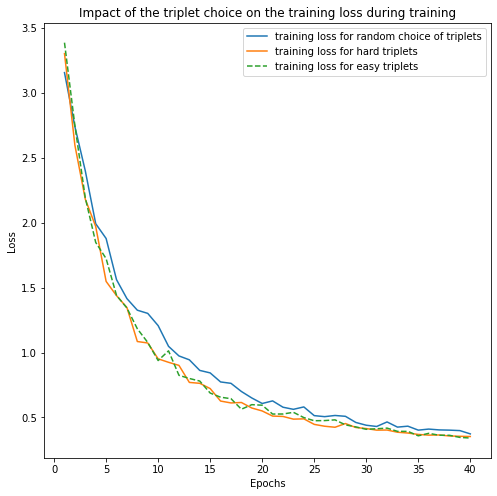

In [ ]:
plt.figure(figsize=(8, 8))
history_dict1 = history_random.history
history_dict2 = history_hard.history
history_dict3 = history_easy.history

loss_values1 = history_dict1['loss']
loss_values2 = history_dict2['loss']
loss_values3 = history_dict3['loss']

epochs = range(1, len(loss_values1) + 1)
plt.plot(epochs, loss_values1, label='training loss for random choice of triplets')
plt.plot(epochs, loss_values2, label='training loss for hard triplets')
plt.plot(epochs, loss_values3, label='training loss for easy triplets', linestyle='--')
plt.title('Impact of the triplet choice on the training loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:

number_of_processes = 10
size_of_encoding_triplet = 128


nb = np.arange(10,40,1)
acc_triplet_random = []
acc_triplet_hard = []
acc_triplet_easy = []
for number_of_processes in nb:
  acc1 = n_way_one_shotlearning (Shared_DNN_random, all_train,all_test, number_of_processes ,
                                 'triplet',size_of_encoding_triplet,'hard')
  acc2 = n_way_one_shotlearning (Shared_DNN_hard, all_train,all_test, number_of_processes ,
                                 'triplet',size_of_encoding_triplet,'hard')
  acc3 = n_way_one_shotlearning (Shared_DNN_easy, all_train,all_test, number_of_processes , 
                                 'triplet',size_of_encoding_triplet,'hard')
  acc_triplet_random.append(acc1[1])
  acc_triplet_hard.append(acc2[1])
  acc_triplet_easy.append(acc3[1])

In [ ]:
np.mean(acc_triplet_random), np.mean(acc_triplet_hard), np.mean(acc_triplet_easy)

(0.6172763765632321, 0.5754576611613226, 0.5832568940458193)

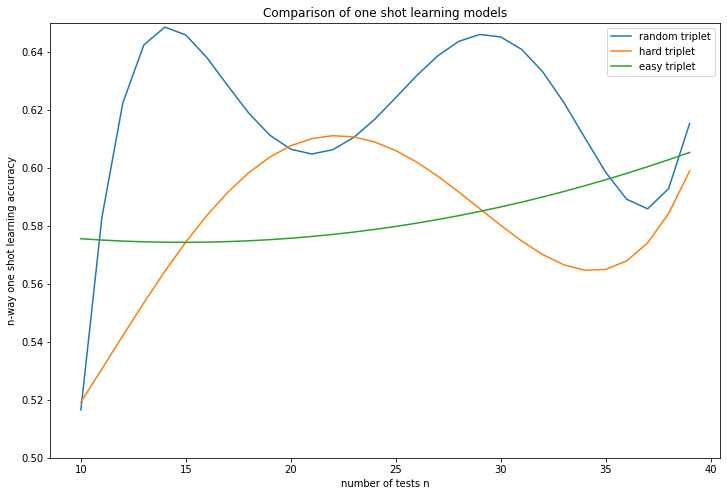

In [ ]:
plt.figure(figsize=(12,8))
poly = np.polyfit(nb,acc_triplet_random,5)
poly_y1 = np.poly1d(poly)(nb)
poly = np.polyfit(nb,acc_triplet_hard,4)
poly_y2 = np.poly1d(poly)(nb)
poly = np.polyfit(nb,acc_triplet_easy,2)
poly_y3 = np.poly1d(poly)(nb)
plt.plot(nb,poly_y1,label='random triplet')
plt.plot(nb,poly_y2,label='hard triplet')
plt.plot(nb,poly_y3,label='easy triplet')
plt.xlabel('number of tests n')
plt.ylabel('n-way one shot learning accuracy')
plt.ylim(0.5,0.65)
plt.title('Comparison of one shot learning models')
plt.legend()

plt.show()